## Importing libraries

In [30]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split

## Loading the data

In [31]:
url_data = 'https://raw.githubusercontent.com/TeodorRusKvi/Tekstanalyse/main/git_NLP_data/'

# Last inn 'X_train_LSTM' fra en CSV-fil
X_df = pd.read_csv(url_data+'X_tensorflow.csv')
# Konverter hele DataFrame til et NumPy array
X = X_df.to_numpy()

# Last inn 'y_train_LSTM' fra en CSV-fil
y_df = pd.read_csv(url_data+'y_liberal.csv')
# Konverter hele DataFrame til et NumPy array
y = y_df.to_numpy()

# Last inn 'y_train_LSTM' fra en CSV-fil
embeddings_GloVe = pd.read_csv(url_data+'embeddings_glove.csv')
# Konverter hele DataFrame til et NumPy array
embeddings_GloVe = embeddings_GloVe.to_numpy()


In [32]:
# Last inn 'X_train_LSTM' fra en CSV-fil
X_df = pd.read_csv(url_data+'X_text.csv')
# Konverter hele DataFrame til et NumPy array
X = X_df.to_numpy().flatten()


tokenizer = Tokenizer(oov_token='<OOV>') # Hyperparameters = num_words=vocab_size, oov_token=oov_tok
tokenizer.fit_on_texts(X)

#Creating a word index of the words from the tokenizer 
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.\n\nFirst 10 is listen below:')
print(dict(list(word_index.items())[0:10]))

Found 22234 unique tokens.

First 10 is listen below:
{'<OOV>': 1, 'people': 2, 'like': 3, 'work': 4, 'right': 5, 'trump': 6, 'think': 7, 'state': 8, 'government': 9, 'party': 10}


In [33]:
# Defining pre-processing hyperparameters for the networks
max_len = 100
trunc_type = "post"
padding_type = "post"
vocab_size = len(word_index)
# This is fixed.
embedding_dim = 100

# Encoding the sequences from the reddit posts
X = tokenizer.texts_to_sequences(X)
# Padding the sequences to keep the lengths uniform
X = pad_sequences(X, maxlen=max_len, padding=padding_type, truncating=trunc_type)


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

In [34]:
# Loading the params from CNN-LSTM from the saved JSON-fil
with open('Hypertuning_trials/best_trial_1.json', 'r') as f:
    data = json.load(f)
    params = data['params']

## A simpel LSTM model with tuned hyperparameters

In [35]:
tf.random.set_seed(42)


def model_build(params):
    lstm_units = params['lstm_units']
    dense_2_units = params['dense_2_units']
    dropout_rate = params['dropout_rate']
    learning_rate = params['learning_rate']
    model = Sequential()
    model.add(Input(shape=(max_len,)))
    # Adding the Embedding layer with pre-trained weights and specifying input_length
    model.add(Embedding(input_dim=embeddings_GloVe.shape[0],
                        output_dim=embeddings_GloVe.shape[1],
                        weights=[embeddings_GloVe],
                        trainable=False))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(lstm_units, # Number of hidden states, number of reccurent units for each vector
        activation='tanh',
        recurrent_activation='sigmoid',
        recurrent_dropout=0.2,
        return_sequences=False)))
    
    model.add(BatchNormalization())

    model.add(Dense(dense_2_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

num_classes = 1
model = model_build(params)
# Model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          2223500   
                                                                 
 dropout_5 (Dropout)         (None, 100, 100)          0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 160)               115840    
 onal)                                                           
                                                                 
 batch_normalization (Batch  (None, 160)               640       
 Normalization)                                                  
                                                                 
 dense_4 (Dense)             (None, 92)                14812     
                                                                 
 dropout_6 (Dropout)         (None, 92)               

In [36]:
num_classes = 1
EPOCHS=20
BATCH_SIZE = 32

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)


history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_val, y_val),
                    batch_size=BATCH_SIZE,
                    callbacks=early_stopping_callback)

Epoch 1/20
282/282 [==============================] - 93s 257ms/step - loss: 0.6250 - accuracy: 0.6676 - val_loss: 0.6096 - val_accuracy: 0.6919
Epoch 2/20
282/282 [==============================] - 76s 268ms/step - loss: 0.5548 - accuracy: 0.7240 - val_loss: 0.5576 - val_accuracy: 0.7111
Epoch 3/20
282/282 [==============================] - 85s 301ms/step - loss: 0.5174 - accuracy: 0.7431 - val_loss: 0.5499 - val_accuracy: 0.7210
Epoch 4/20
282/282 [==============================] - 2137s 8s/step - loss: 0.4818 - accuracy: 0.7693 - val_loss: 0.5116 - val_accuracy: 0.7474
Epoch 5/20
282/282 [==============================] - 72s 256ms/step - loss: 0.4445 - accuracy: 0.7943 - val_loss: 0.5203 - val_accuracy: 0.7474
Epoch 6/20
282/282 [==============================] - 36s 127ms/step - loss: 0.4133 - accuracy: 0.8115 - val_loss: 0.6319 - val_accuracy: 0.7422
Epoch 7/20
282/282 [==============================] - 53s 188ms/step - loss: 0.3770 - accuracy: 0.8233 - val_loss: 0.5647 - val_acc

## Evaluation of the model

61/61 [==============================] - 4s 60ms/step - loss: 0.5667 - accuracy: 0.7475
Test Loss: 0.566677987575531
Test Accuracy: 0.7475376129150391


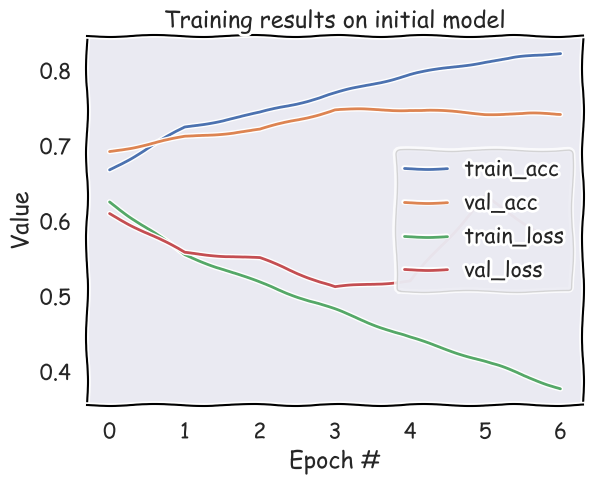

In [37]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

with plt.xkcd():
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')



    plt.xlabel('Epoch #')
    plt.ylabel('Value')
    plt.title('Training results on initial model')
    plt.legend()

    plt.show()

## Classification metrics

31/31 [==============================] - 4s 112ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.60      0.63       681
           1       0.79      0.83      0.81      1248

    accuracy                           0.75      1929
   macro avg       0.72      0.71      0.72      1929
weighted avg       0.74      0.75      0.74      1929

Accuracy: 0.7475375842405392
Recall: 0.8285256410256411
Precision: 0.791124713083397
F1 Score: 0.8093933463796478


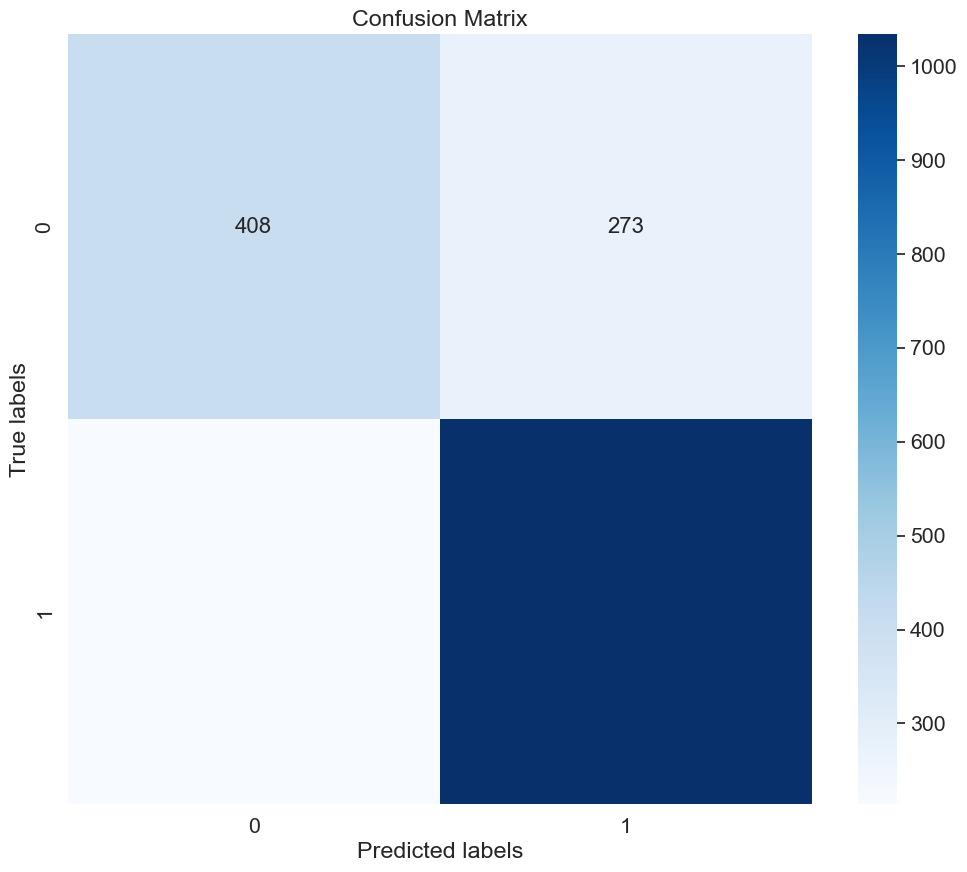

In [38]:
# Predict probabilities for the positive class (class 1)
probabilities = model.predict(X_test, batch_size=64)

# Ensure that probabilities are in the expected format
y_pred = (probabilities > 0.5).astype(int).flatten()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calculating different metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print each metric
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)

# Creating a confusion matrix for visualization
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(12,10))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues')  # fmt='g' to avoid scientific notation

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()